In [3]:
import lightgbm

best_params = {
    'objective': 'regression',
    'metric': 'rmse',
    "verbosity": -1,
    'boosting_type': 'gbdt',
    'num_leaves': 128,
    'learning_rate': 0.9142244642559713,
    'min_child_samples': 42,
    'min_child_weight': 82.67196585530857,
    'subsample': 0.8484409608430301,
    'subsample_freq': 10,
    'colsample_bytree': 0.7233264088685998,
    'reg_alpha': 21.228348804552645,
    'reg_lambda': 87.17459207514409,
    'max_depth': 14,
    'min_split_gain': 0.053099560774982534
}


In [4]:
import json
import pandas as pd
import numpy as np

with open('../data/for_training/features.json') as f:
    column_names = json.load(f)

feature_columns = column_names['features']
target_column = column_names['target']

train_df = pd.read_csv('../data/for_training/train.csv')
val_df = pd.read_csv('../data/for_training/valid.csv')

y_train = np.log1p(train_df[target_column])
y_valid = np.log1p(val_df[target_column])
x_train = train_df[feature_columns]
x_valid = val_df[feature_columns]

train_data = lightgbm.Dataset(x_train, label=y_train)
model = lightgbm.train(best_params, train_data)

## Model evaluation

In [6]:
from sklearn.metrics import mean_squared_error

y_pred = model.predict(x_valid)
rmse = mean_squared_error(y_valid, y_pred, squared=False)
print(f'RMSE: {rmse}')

RMSE: 0.47350310197843565


## Feature importance
plotting top 10 features

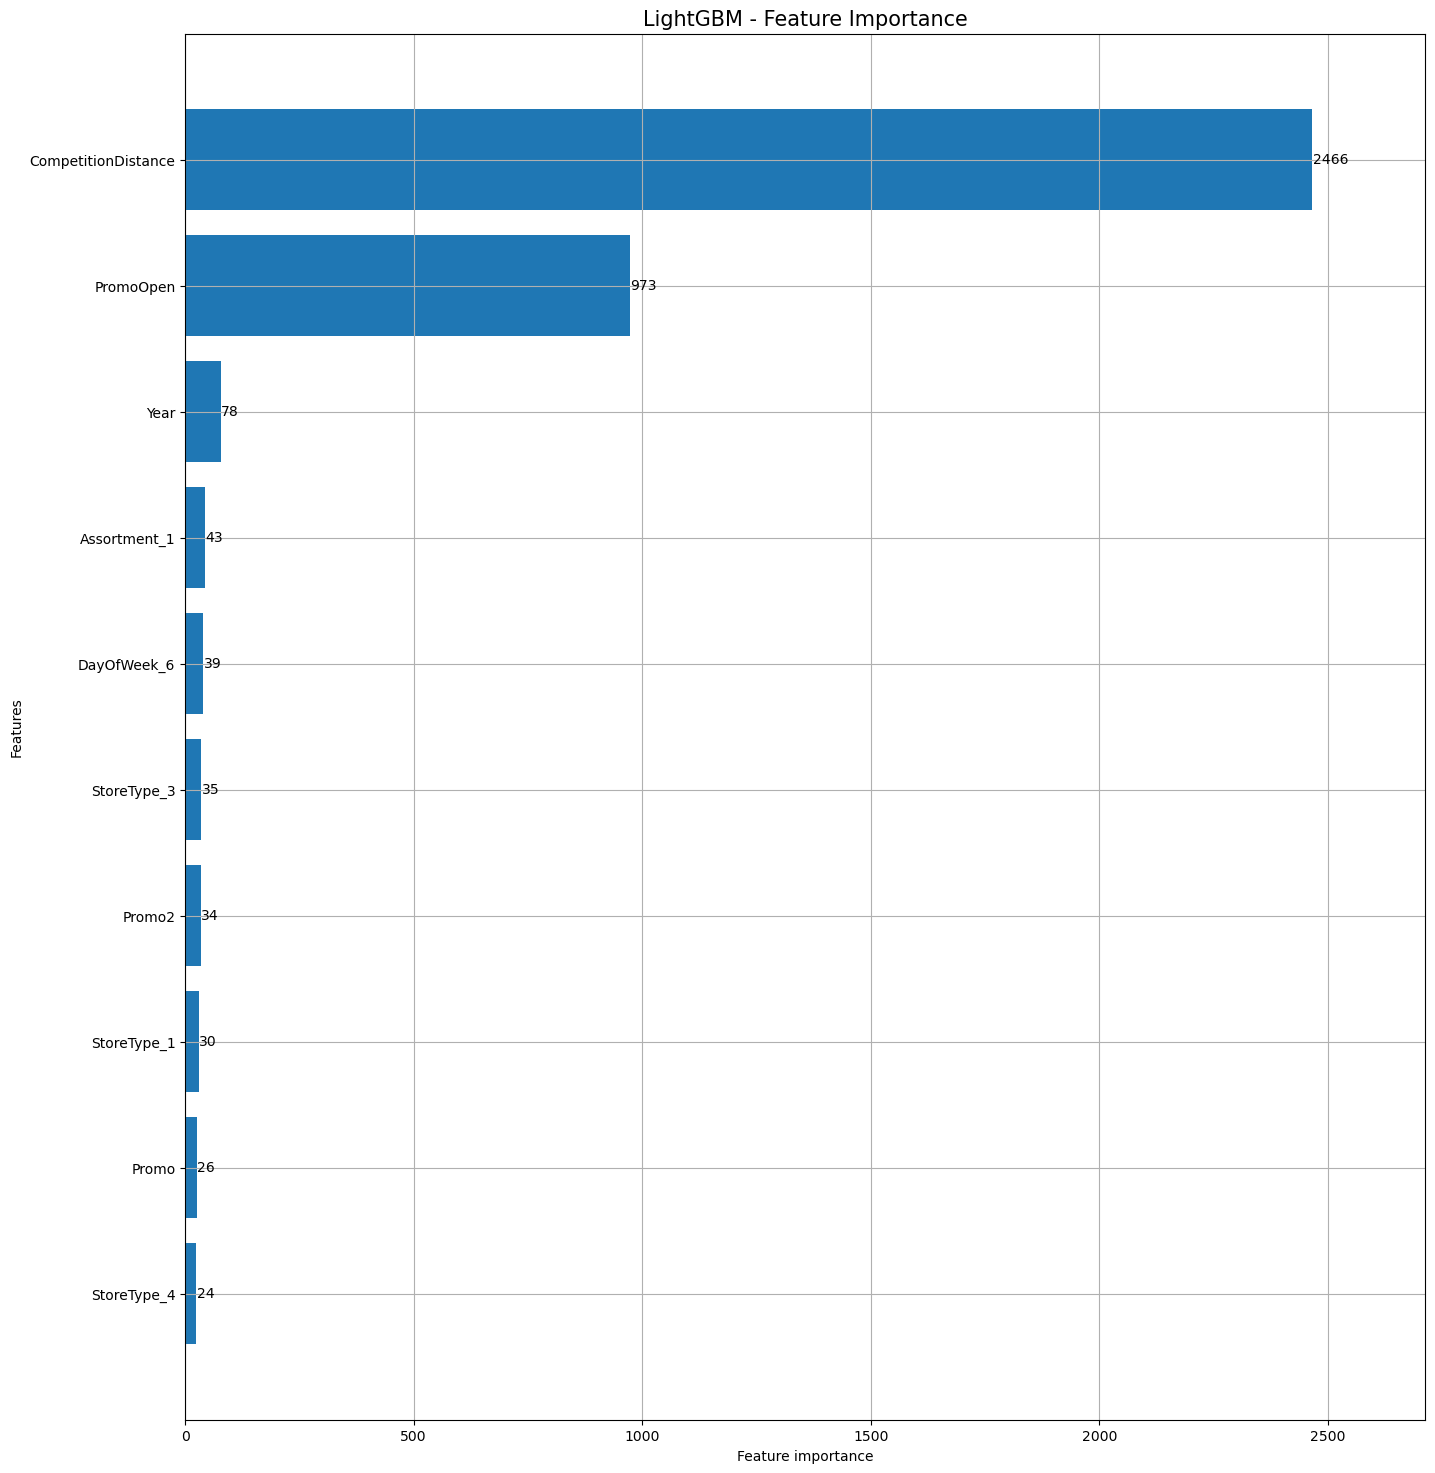

In [9]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(16, 18))
lightgbm.plot_importance(model, max_num_features=10, height=0.8, ax=ax)
plt.title("LightGBM - Feature Importance", fontsize=15)
plt.show()


## Prediction value on Competition distance

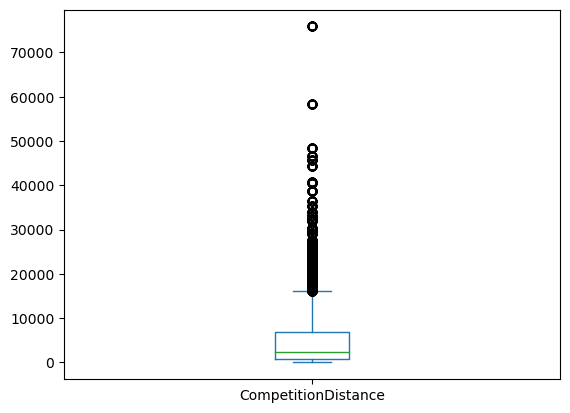

In [13]:
# take an example of x_valid change competition distance and see how the results change
# plot boxplot of CompetitionDistance column in x_valid

x_valid['CompetitionDistance'].plot.box()
plt.show()

as we can see most part of the competition distance is between 0 and 20_000

In [21]:
example = x_valid.iloc[0].copy()

example_df = pd.DataFrame([example] * 1000)
example_df['CompetitionDistance'] = np.linspace(0, 20_000, 1000)
example_df.head()

,CompetitionDistance,Promo,Promo2,SchoolHoliday,Year,PromoOpen,IsPromoMonth,DayOfWeek_0,DayOfWeek_1,DayOfWeek_2,...,StoreType_2,StoreType_3,StoreType_4,Assortment_1,Assortment_2,Assortment_3,StateHoliday_0,StateHoliday_1,StateHoliday_2,StateHoliday_3
0,0.00000,0.0,0.0,1.0,2013.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
0,20.02002,0.0,0.0,1.0,2013.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
0,40.04004,0.0,0.0,1.0,2013.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
0,60.06006,0.0,0.0,1.0,2013.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
0,80.08008,0.0,0.0,1.0,2013.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0


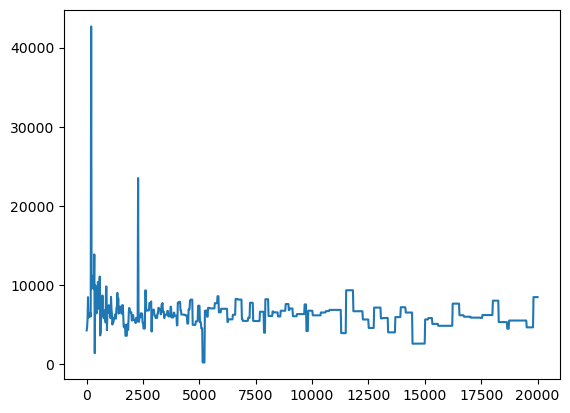

In [22]:
results = model.predict(example_df[feature_columns])
# upscale the results
results = np.expm1(results)
plt.plot(example_df['CompetitionDistance'], results)
plt.show()

We would assume that the competition distance would have a negative impact on the sales. In here we only analysed one example, and it's not enough to make any decisions here. Probably better way would be to do this on every store and then average the results.

In [33]:
from tqdm import tqdm

results_list = []

for i, row in tqdm(x_valid[:10_000].iterrows(), total=10_000):
    example_df = pd.DataFrame([row] * 1000)
    example_df['CompetitionDistance'] = np.linspace(0, 20_000, 1000)
    results = model.predict(example_df[feature_columns])
    results = np.expm1(results)
    results_list.append(results)

100%|██████████| 10000/10000 [02:26<00:00, 68.15it/s]


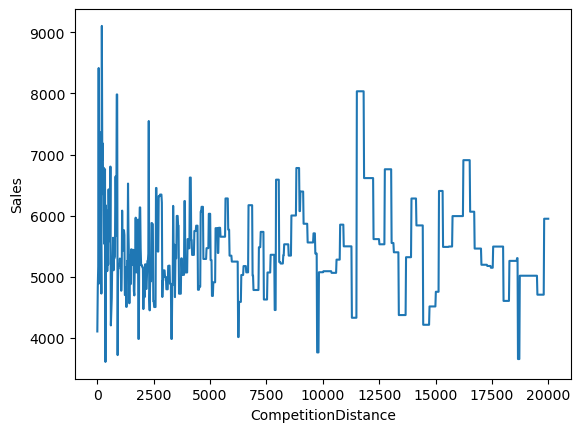

In [36]:
results_list = np.array(results_list)


sales_mean = np.mean(results_list, axis=0)
plt.plot(np.linspace(0, 20_000, 1000), sales_mean)
# write column names to the plot's axis
plt.xlabel('CompetitionDistance')
plt.ylabel('Sales')
plt.show()